In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.set_default_tensor_type(torch.DoubleTensor)
import pyro
import pyro.distributions as dist
import torch.distributions.constraints as constraints

Suppose a really simple grammar for producing a scene (of 1D objects):

Root -> Intermediate, nominally with dx ~ N(0, 1)
Intermediate -> Observed, nominally with dx ~ N(0, 1)

If we generate a dataset of observation from this model (with those nominal parameters), we should see a Normally-distributed observation set with variance 1+1=2.

Observed variance of observations:  tensor(2.0303)


Text(0.5, 1.0, 'Observation distribution with default parameters')

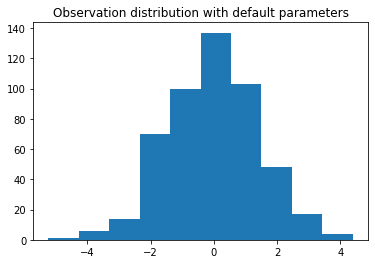

In [8]:
pyro.clear_param_store()
def model(data):
    root_to_int_offset_dist = dist.Normal(
        pyro.param("root_dx_mean", torch.tensor([0.])),
        pyro.param("root_dx_var", torch.tensor([1.]), constraint=constraints.positive)
    )
    int_to_observed_offset_dist = dist.Normal(
        pyro.param("int_dx_mean", torch.tensor([0.])),
        pyro.param("int_dx_var", torch.tensor([1.]), constraint=constraints.positive)
    )
    with pyro.plate('data', len(data)):
        root = torch.zeros(1)
        intermediate = root + pyro.sample("root_dx", root_to_int_offset_dist)
        observed = intermediate + pyro.sample("int_dx", int_to_observed_offset_dist)
        x_obs = pyro.sample("x_obs", dist.Normal(observed, torch.ones(1)*0.001), obs=data)
        assert torch.allclose(x_obs, data)
    return observed

observed_data = model(torch.zeros(500,)).detach()
print("Observed variance of observations: ", torch.var(observed_data))
plt.hist(observed_data.flatten().numpy())
plt.title("Observation distribution with default parameters")

We can take that dataset, randomize our model parameters, and try to recover MAP model parameters.

  0%|          | 0/100 [00:00<?, ?it/s]

Variance of observations post-fit:  tensor(1.4548)


Text(0.5, 1.0, 'Observation distribution with fit parameters')

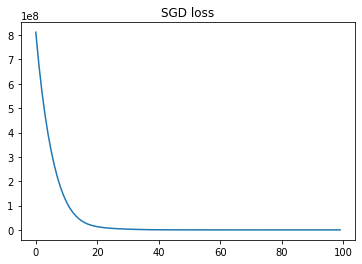

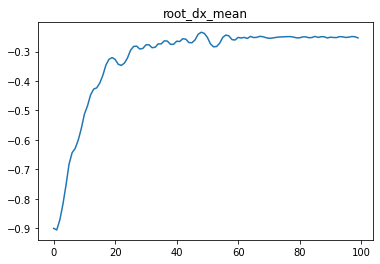

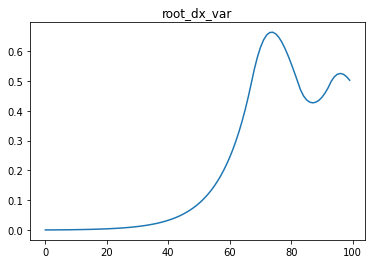

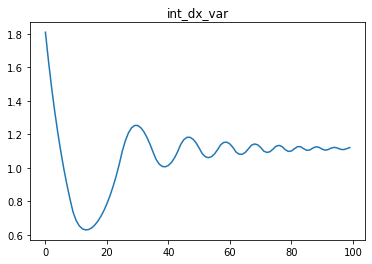

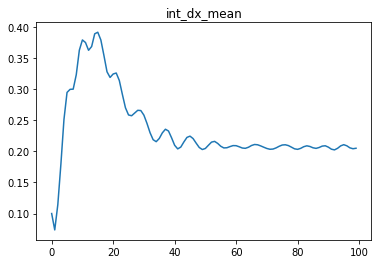

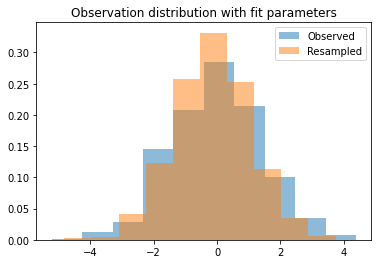

In [9]:
from pyro.infer import SVI, Trace_ELBO, SVGD, RBFSteinKernel
from pyro.optim import ClippedAdam
from pyro.infer.autoguide import AutoNormal, AutoDelta, AutoIAFNormal
from tqdm.notebook import tqdm
from copy import deepcopy

pyro.clear_param_store()
pyro.param("root_dx_mean", torch.tensor([-1.]))
pyro.param("root_dx_var", torch.tensor([0.001]), constraint=constraints.positive)
pyro.param("int_dex_mean", torch.tensor([1.]))
pyro.param("int_dx_var", torch.tensor([2.]), constraint=constraints.positive)

guide = AutoDelta(model)
#guide = AutoNormal(model)
#guide = AutoIAFNormal(model)
def get_args(module_name, param_name):
    if "arn" in param_name: # IAF normal stuff
        return {"lr": 1E-4, "weight_decay": 1E-3, "lrd": 0.99}
    else:
        return {"lr": 0.1}
optimizer = ClippedAdam(get_args)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

iterator = tqdm(range(100))
losses = []
expected_keys = ["root_dx_mean", "root_dx_var", "int_dx_mean", "int_dx_var"]
param_history = {}
for step in iterator:
    loss = svi.step(observed_data)
    iterator.set_description("%f" % loss)
    losses.append(loss)
    
    for key, value in pyro.get_param_store().items():
        if key not in expected_keys:
            continue
        if key not in param_history.keys():
            param_history[key] = []
        param_history[key].append(deepcopy(value.detach()))

plt.plot(losses)
plt.title("SGD loss")
for key, history in param_history.items():
    if key not in expected_keys:
        continue
    plt.figure()
    plt.title(key)
    plt.plot(torch.stack(history))

resampled_data = model(torch.zeros(1000,)).detach()
print("Variance of observations post-fit: ", torch.var(resampled_data))
plt.figure()
plt.hist(observed_data.flatten().numpy(), label="Observed", alpha=0.5, density=True)
plt.hist(resampled_data.flatten().numpy(), label="Resampled", alpha=0.5, density=True)
plt.legend()
plt.title("Observation distribution with fit parameters")

If run with an AutoNormal guide (i.e. a mean-field diagonal normal guide), VI dramatically underestimates variance (spits out variances ~0.7). If using the richer IAF autoguide that can capture inter-variable dependencies, the product is better (but still slightly estimating variances at ~0.95).

VI underestimates the variance here, but balances the low variance between the two distribution parts. Remember that the VI objective minimizes $ KL(q, p(z | x)) = \int q(z) \log(p(z | x) / q(z)) dz $, which wants q to be inside the true posterior (but doesn't care about what's going on outside of q). This is the "mode seeking" behavior I hear about.

I think a piece of this puzzle is that, in this example, the "true" posterior over the latent displacements is very narrow with respect to a single displacement, but is very broad with respect to simultaneous change of both displacements. So this might be a pathologically bad case for mean-field VI.

  0%|          | 0/200 [00:00<?, ?it/s]

Variance of observations post-fit:  tensor(1.1365)


Text(0.5, 1.0, 'Observation distribution with fit parameters')

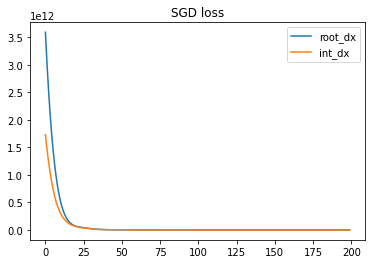

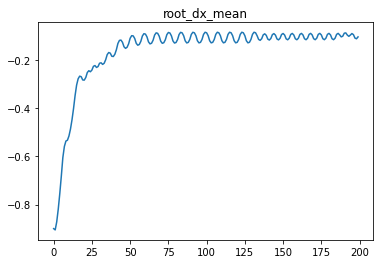

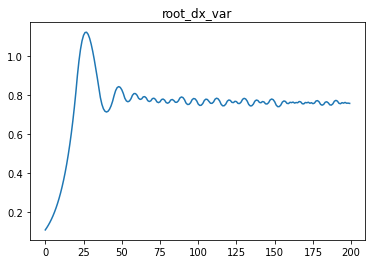

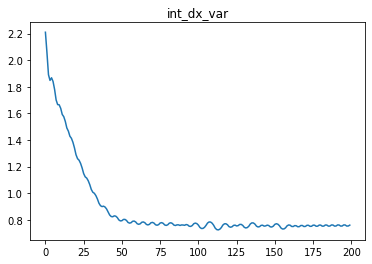

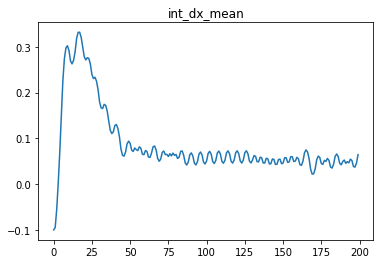

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


Error in callback <function flush_figures at 0x7f5410a91378> (for post_execute):


KeyboardInterrupt: 

In [4]:
from pyro.infer import SVGD, RBFSteinKernel, IMQSteinKernel
from pyro.optim import ClippedAdam
from tqdm.notebook import tqdm
from copy import deepcopy

pyro.clear_param_store()
# Perturb initial parameters
pyro.param("root_dx_mean", torch.tensor([-1.]))
pyro.param("root_dx_var", torch.tensor([0.1]), constraint=constraints.positive)
pyro.param("int_dex_mean", torch.tensor([1.]))
pyro.param("int_dx_var", torch.tensor([2.]), constraint=constraints.positive)


optimizer = ClippedAdam({"lr": 0.1})
kernel = RBFSteinKernel()
kernel = IMQSteinKernel()
svgd = SVGD(model, kernel, optimizer, num_particles=10, max_plate_nesting=1)

iterator = tqdm(range(200))
losses = {}
expected_keys = ["root_dx_mean", "root_dx_var", "int_dx_mean", "int_dx_var"]
param_history = {}
for step in iterator:
    loss = svgd.step(observed_data)
    iterator.set_description("%f" % sum(loss.values()))
    for key, value in loss.items():
        if key not in losses.keys():
            losses[key] = []
        losses[key].append(value)
    
    for key, value in pyro.get_param_store().items():
        if key not in expected_keys:
            continue
        if key not in param_history.keys():
            param_history[key] = []
        param_history[key].append(deepcopy(value.detach()))

plt.figure()
for key, loss_hist in losses.items():
    plt.plot(loss_hist, label=key)
plt.legend()
plt.title("SGD loss")
for key, history in param_history.items():
    if key not in expected_keys:
        continue
    plt.figure()
    plt.title(key)
    plt.plot(torch.stack(history))

resampled_data = model(torch.zeros(1000,)).detach()
print("Variance of observations post-fit: ", torch.var(resampled_data))
plt.figure()
plt.hist(observed_data, label="Observed", alpha=0.5, density=True)
plt.hist(resampled_data, label="Resampled", alpha=0.5, density=True)
plt.legend()
plt.title("Observation distribution with fit parameters")